In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Convolution1D, MaxPooling1D, LSTM
from keras.layers import Input, Conv1D, MaxPool1D, Bidirectional, GRU
from keras.layers.merge import concatenate
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
# DATASET
#DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "https?:\S+|http?:\S"

# WORD2VEC 
W2V_SIZE = 200
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 5

# KERAS
SEQUENCE_LENGTH = 50
EPOCHS = 32
BATCH_SIZE = 256

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
# read dataset
dataset_filename = os.listdir("./data")[0]
dataset_path = os.path.join(".","data","cong_politician_tweets.csv")
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING)
print(df.head(5))

Open file: ./data/cong_politician_tweets.csv


/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (17,62,63,64,65,66,67,96) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


       user_id             status_id           created_at screen_name  \
0  x1262017122  x1235708269060075523  2020-03-05 23:26:24   Abby4Iowa   
1  x1262017122  x1235648562320609280  2020-03-05 19:29:09   Abby4Iowa   
2  x1262017122  x1235630185359323136  2020-03-05 18:16:07   Abby4Iowa   
3  x1262017122  x1235598400097116161  2020-03-05 16:09:49   Abby4Iowa   
4  x1262017122  x1235597648272470023  2020-03-05 16:06:50   Abby4Iowa   

                                                text              source  \
0  Iâve lived with Stage 4 endometriosis for ye...  Twitter for iPhone   
1  "To be a woman, talking about what disadvantag...  Twitter for iPhone   
2  <U+2764><U+FE0F> Heâs my best friend and weâ...  Twitter for iPhone   
3  1 in 10 women suffer from endometriosis.\r\n\r...  Twitter for iPhone   
4  Good morning to @Abby4Iowa who's inspiring me ...  Twitter for iPhone   

   display_text_width reply_to_status_id reply_to_user_id  \
0                 139                NaN   

In [5]:
df = df.sample(30000, random_state=123)
df.to_csv("./data/cong_politician_tweets30000.csv")

In [8]:
df = df.sample(200000, random_state=123)
df.to_csv("./data/cong_politician_tweets200000.csv")

In [3]:
df = pd.read_csv("./data/cong_politician_tweets200000.csv", encoding = "ISO-8859-1")

/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,7,11,12,14,15,16,18,77,78,79,80,81,84,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = pd.read_csv("./data/cong_politician_tweets500000.csv", encoding = "ISO-8859-1")

/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,28,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,46,47,48,49,50,51,54,55,56,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df['party'] = df['party'].map({'D':0, 'R':1})

In [6]:
decode_map = {0: "Democratic", 3: "NEUTRAL", 1: "Republican"}
def decode_sentiment(label):
    return decode_map[int(label)]
print(decode_sentiment(1))
print(decode_map[0])
print(int(1))

Republican
Democratic
1


In [7]:
%%time
df.party = df.party.apply(lambda x: decode_sentiment(x))

ValueError: cannot convert float NaN to integer

Text(0.5, 1.0, 'Dataset labels distribuition')

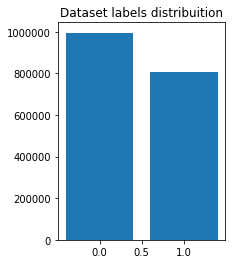

In [5]:
target_cnt = Counter(df.party)

plt.figure(figsize=(3,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Pre-Process dataset

In [6]:
## do not remove stop words
def preprocess(text, stem=False):
    # Remove link
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text)).strip()
    # remove @
    text = re.sub("@|#", ' ', text)
    return(text)

In [7]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 5.97 s, sys: 103 ms, total: 6.07 s
Wall time: 6.08 s


In [8]:
df.text

0          Iâve lived with Stage 4 endometriosis for ye...
1          "To be a woman, talking about what disadvantag...
2          <U+2764><U+FE0F> Heâs my best friend and weâ...
3          1 in 10 women suffer from endometriosis.\r\n\r...
4          Good morning to  Abby4Iowa who's inspiring me ...
                                 ...                        
1799848    MT  vkritzer: I'm proud to have helped elect  ...
1799849    To help in the fight to end the  NSA's mass su...
1799850    Here's Becca in the stadium waiting for the ra...
1799851    Happy 21st anniversary to the  FMLA! By helpin...
1799852    Marshawn Lynch is sitting on the hood of the f...
Name: text, Length: 1799853, dtype: object

In [37]:
df.head()

,Unnamed: 0,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,...,profile_banner_url,profile_background_url,profile_image_url,ÃÂ¯..bioguide,full_name,chamber,party,state,state_full,district
0,1215640,x303633791,x927908226993131525,2017-11-07 14:38:55,Nanette4CA,Millennials/youth: Did you know the @GOP tax p...,Twitter for iPhone,139,NaN,NaN,...,https://pbs.twimg.com/profile_banners/30363379...,http://abs.twimg.com/images/themes/theme4/bg.gif,http://pbs.twimg.com/profile_images/1038887786...,B001300,Nanette BarragÃÂÃÂ¡n,House,0.0,CA,California,44th
1,1542909,x389840566,x1086050203755520002,2019-01-17 23:58:41,RepHorsford,I ran for Congress to fight to lower prescript...,Twitter Web Client,221,NaN,NaN,...,https://pbs.twimg.com/profile_banners/38984056...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1228726807...,H001066,Steven Horsford,House,0.0,NV,Nevada,4th
2,249665,x47747074,x1161447053399998464,2019-08-14 01:18:50,brianschatz,@saraphudson He lost,Twitter for iPhone,7,x1161446553669779458,x247841565,...,https://pbs.twimg.com/profile_banners/47747074...,http://abs.twimg.com/images/themes/theme5/bg.gif,http://pbs.twimg.com/profile_images/8401792854...,S001194,Brian Schatz,Senate,0.0,HI,Hawaii,NaN
3,1720160,x4424118432,x693567671472930817,2016-01-30 22:53:13,Vicentecongress,"I posted 3 photos on Facebook in the album ""20...",Facebook,93,NaN,NaN,...,https://pbs.twimg.com/profile_banners/44241184...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/6717986931...,G000581,Vicente Gonzalez,House,0.0,TX,Texas,15th
4,1514867,x310310133,x1111724805680709638,2019-03-29 20:20:23,RepStephenLynch,Over 2.7 million men and women served during t...,Twitter Web Client,146,NaN,NaN,...,https://pbs.twimg.com/profile_banners/31031013...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/5231215301...,L000562,Stephen F. Lynch,House,0.0,MA,Massachusetts,8th


In [9]:
df = df[df.party.notna()]

Split train and test

In [10]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1439882
TEST size: 359971


Word2Vec

In [57]:
#w2v_model = gensim.models.Word2Vec.load("model.w2v")

In [58]:
%%time
documents = [_text.split() for _text in df_train.text] ## what's the purpose here?
print(documents[0])

['Proud', 'to', 'announce', 'the', 'endorsement', 'of', 'my', 'dear', 'friend', 'RubenGallego', 'LD24', 'Ruben', 'and', 'I', 'have', 'been', 'working', 'in', 'the', 'trenches', 'together', 'for', 'almost', 'a', 'decade.']
CPU times: user 775 ms, sys: 35.8 ms, total: 811 ms
Wall time: 828 ms


In [59]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [60]:
w2v_model.build_vocab(documents)

2020-03-15 19:45:14,088 : INFO : collecting all words and their counts
2020-03-15 19:45:14,091 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-03-15 19:45:14,134 : INFO : PROGRESS: at sentence #10000, processed 236803 words, keeping 39362 word types
2020-03-15 19:45:14,177 : INFO : PROGRESS: at sentence #20000, processed 473291 words, keeping 61553 word types
2020-03-15 19:45:14,219 : INFO : PROGRESS: at sentence #30000, processed 712791 words, keeping 80089 word types
2020-03-15 19:45:14,260 : INFO : PROGRESS: at sentence #40000, processed 951145 words, keeping 96024 word types
2020-03-15 19:45:14,304 : INFO : PROGRESS: at sentence #50000, processed 1188451 words, keeping 110694 word types
2020-03-15 19:45:14,344 : INFO : PROGRESS: at sentence #60000, processed 1425045 words, keeping 124405 word types
2020-03-15 19:45:14,388 : INFO : PROGRESS: at sentence #70000, processed 1665706 words, keeping 137219 word types
2020-03-15 19:45:14,436 : INFO : PROGRES

In [61]:
words_w = w2v_model.wv.vocab.keys()
#print(len(w2v_model.wv["u"]))
#print(list(w2v_model.wv.vocab.items())[0:5])
vocab_size = len(words_w)
print("Vocab size", vocab_size)

Vocab size 38188


In [62]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH) ##?

2020-03-15 19:45:28,952 : INFO : training model with 8 workers on 38188 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-03-15 19:45:29,961 : INFO : EPOCH 1 - PROGRESS: at 37.84% examples, 1085164 words/s, in_qsize 16, out_qsize 1
2020-03-15 19:45:30,973 : INFO : EPOCH 1 - PROGRESS: at 80.96% examples, 1154113 words/s, in_qsize 15, out_qsize 0
2020-03-15 19:45:31,362 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-15 19:45:31,363 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-15 19:45:31,379 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-15 19:45:31,380 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-15 19:45:31,383 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-15 19:45:31,389 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-15 19:45:31,394 : INFO : worker thread finished; awaiting finish o

2020-03-15 19:45:47,562 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-15 19:45:47,564 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-15 19:45:47,566 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-15 19:45:47,568 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-15 19:45:47,569 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-15 19:45:47,572 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-15 19:45:47,573 : INFO : EPOCH - 8 : training on 3799769 raw words (2869952 effective words) took 2.3s, 1263764 effective words/s
2020-03-15 19:45:48,581 : INFO : EPOCH 9 - PROGRESS: at 44.85% examples, 1287929 words/s, in_qsize 16, out_qsize 0
2020-03-15 19:45:49,582 : INFO : EPOCH 9 - PROGRESS: at 89.86% examples, 1288545 words/s, in_qsize 15, out_qsize 0
2020-03-15 19:45:49,762 : INFO : worker thread finished; awaiting finish of 7 more thr

2020-03-15 19:46:03,460 : INFO : EPOCH - 15 : training on 3799769 raw words (2869504 effective words) took 2.3s, 1252304 effective words/s
2020-03-15 19:46:04,468 : INFO : EPOCH 16 - PROGRESS: at 43.27% examples, 1242870 words/s, in_qsize 15, out_qsize 0
2020-03-15 19:46:05,490 : INFO : EPOCH 16 - PROGRESS: at 89.34% examples, 1268236 words/s, in_qsize 16, out_qsize 1
2020-03-15 19:46:05,677 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-15 19:46:05,683 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-15 19:46:05,696 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-15 19:46:05,702 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-15 19:46:05,708 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-15 19:46:05,714 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-15 19:46:05,717 : INFO : worker thread finished; awaiting finish of 1 more 

2020-03-15 19:46:21,364 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-15 19:46:21,375 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-15 19:46:21,376 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-15 19:46:21,380 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-15 19:46:21,382 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-15 19:46:21,383 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-15 19:46:21,384 : INFO : EPOCH - 23 : training on 3799769 raw words (2870458 effective words) took 2.2s, 1291263 effective words/s
2020-03-15 19:46:22,390 : INFO : EPOCH 24 - PROGRESS: at 44.85% examples, 1289282 words/s, in_qsize 14, out_qsize 0
2020-03-15 19:46:23,391 : INFO : EPOCH 24 - PROGRESS: at 89.33% examples, 1281367 words/s, in_qsize 15, out_qsize 0
2020-03-15 19:46:23,578 : INFO : worker thread finished; awaiting finish of 7 more 

2020-03-15 19:46:37,100 : INFO : EPOCH - 30 : training on 3799769 raw words (2870283 effective words) took 2.2s, 1281412 effective words/s
2020-03-15 19:46:38,107 : INFO : EPOCH 31 - PROGRESS: at 44.06% examples, 1265541 words/s, in_qsize 16, out_qsize 0
2020-03-15 19:46:39,118 : INFO : EPOCH 31 - PROGRESS: at 89.60% examples, 1278830 words/s, in_qsize 14, out_qsize 1
2020-03-15 19:46:39,307 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-15 19:46:39,311 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-15 19:46:39,311 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-15 19:46:39,313 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-15 19:46:39,320 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-15 19:46:39,324 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-15 19:46:39,325 : INFO : worker thread finished; awaiting finish of 1 more 

CPU times: user 4min 2s, sys: 949 ms, total: 4min 2s
Wall time: 1min 12s


(91849596, 121592608)

In [63]:
w2v_model.most_similar("love")

/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-03-15 19:46:51,182 : INFO : precomputing L2-norms of word weight vectors


[('love.', 0.5123016834259033),
 ('love,', 0.5002260804176331),
 ('appreciate', 0.47751158475875854),
 ('loves', 0.4660755395889282),
 ('admire', 0.46238261461257935),
 ('cherish', 0.45935869216918945),
 ('<U+2764><U+FE0F>', 0.43780699372291565),
 ('pride', 0.42830556631088257),
 ('pray', 0.4216599762439728),
 ('wish', 0.41725432872772217)]

Tokenize Text
https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
explained how keras tokenize texts

In [11]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
print(list(tokenizer.word_index.items())[0:10])

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

[('the', 1), ('to', 2), ('and', 3), ('of', 4), ('in', 5), ('for', 6), ('a', 7), ('\r', 8), ('on', 9), ('is', 10)]
Total words 417465
CPU times: user 35.6 s, sys: 27 ms, total: 35.6 s
Wall time: 35.6 s


In [12]:
%%time
print(list(df_train.text)[0:5])
print(tokenizer.texts_to_sequences(df_train.text)[0:5]) # transform to numerical labels

x_try = pad_sequences(tokenizer.texts_to_sequences(df_train.text)[0:5], maxlen=14)
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH) # pad a window to a same lenght
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
print(x_try)

['I signed a letter to House leadership to support our service members of  NationalService within the disaster relief fund.  LetUsServe', "I joined health care professionals, activists &amp; law enforcement in Hartford to discuss the staggering number of opioid overdoses. We need action not more rhetoric. That's why colleagues &amp; I've introduced the CARE Act to provide federal resources to confront &amp; combat this epidemic", 'Senator Inhofe: U.S. may not win if attacked by one of two world powers', 'RT  usrepjoewilson: Grateful for  RepMikeTurner and his efforts to strengthen measures addressing sexual assault and misconduct within...', 'Roberts: We must focus on program integrity and commonsense investments to strengthen our nutrition programs to ensure the pathway to long-term success of those in need of assistance.  farmbill18']
[[15, 526, 7, 480, 2, 50, 253, 2, 57, 11, 155, 190, 4, 11193, 1857, 1, 811, 762, 665, 66740], [15, 295, 70, 87, 2594, 2625, 13, 140, 621, 5, 6112, 2, 1

In [29]:
y[y.isna()]

NameError: name 'y' is not defined

Label Encoder

In [13]:
labels = df_train.party.unique().tolist() # tolist() make pandas series to a list
print(labels)
labels.append(NEUTRAL)
labels

[0, 1]


[0, 1, 'NEUTRAL']

In [14]:
encoder = LabelEncoder()
encoder.fit(df_train.party.tolist())

y_train = encoder.transform(df_train.party.tolist()) # transform non-numerical data to numerical labels
y_test = encoder.transform(df_test.party.tolist())

ylist = list(y_train)
print(set(ylist))

y_train = y_train.reshape(-1,1) # -1 means unknown
y_test = y_test.reshape(-1,1)

print(y_train[0:5])
print("y_train",y_train.shape)
print("y_test",y_test.shape)

{0, 1}
[[0]
 [0]
 [1]
 [1]
 [1]]
y_train (1439882, 1)
y_test (359971, 1)


In [15]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1439882, 50)
y_train (1439882, 1)

x_test (359971, 50)
y_test (359971, 1)


Embedding layer

In [68]:
## word2vector
embedding_matrix = np.zeros((vocab_size, W2V_SIZE)) #Return a new array of given shape and type, filled with zeros.
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)
print(len(embedding_matrix[0]))

(120997, 200)
200


In [14]:
## load glove
#import pandas as pd
import csv

words = pd.read_csv("../sentiment/glove.twitter.27B.200d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

In [ ]:
#https://www.kaggle.com/hamishdickson/bidirectional-lstm-in-keras-with-glove-embeddings

In [16]:
embeddings_index = {}
f = open(os.path.join('../sentiment', 'glove.twitter.27B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193515 word vectors.


In [17]:


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 417464 unique tokens.


In [18]:
#num_words = min(max_features, len(word_index)) + 1
#print(num_words)

embedding_dim = 200

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    #else:
        # doesn't exist, assign a random vector
    #    embedding_matrix[i] = np.random.randn(embedding_dim)

In [1]:
import tensorflow as tf
tf.VERSION

AttributeError: module 'tensorflow' has no attribute 'VERSION'

In [15]:
words.index[1000:1010]
glove_words = list(words.index)

print(type(glove_words))

<class 'list'>


In [73]:
## glove
embedding_matrix = np.zeros((vocab_size, W2V_SIZE)) #Return a new array of given shape and type, filled with zeros.
for word, i in tokenizer.word_index.items():
  if word in glove_words:
    embedding_matrix[i] = words.loc[word]
print(embedding_matrix.shape)
print(len(embedding_matrix[0]))
print(embedding_matrix[17,])

(120997, 200)
200
[ 0.38137    0.36436    0.25135    0.13976    0.026781   0.54802
 -0.27403    0.21689    0.051641   0.49758   -0.21304    0.072604
  0.34352    0.6266    -0.36796    0.086403   0.12861    0.020455
 -0.26107    0.38813   -0.15925   -0.29614    0.6932    -0.039932
  0.10526   -0.093233  -0.47551   -0.33683    0.45248    0.031655
 -0.26894   -0.43397    0.052248   0.56947    0.032317  -0.17017
  0.56397   -0.16769   -0.62177    0.19929   -1.1045     0.78062
  0.71575    0.33675   -0.018591  -0.43137    0.31747   -0.65064
  0.24694   -0.14051    0.29169   -0.28342    0.076483   0.0528
  0.79835   -0.15685   -0.37934   -0.20088    0.43994   -0.33123
 -0.66478   -0.30476    0.34128    0.11896    0.20665    0.11174
 -0.42675   -0.04833   -0.045714   0.44196   -0.12676   -0.35255
  0.39638   -0.47312   -0.40433    0.59931   -0.088971  -0.1241
  0.2348     0.17748    0.044289   0.20437   -0.41906    0.088639
 -0.18172    0.30573   -1.0968    -0.03048    0.050779   0.52375
  0.

In [19]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
#print(embedding_layer)
#embedding_layer2 = Embedding(vocab_size, W2V_SIZE, input_length=SEQUENCE_LENGTH, trainable=True)

In [89]:
print(df_liwc.columns)
print(df_liwc[['Tone','affect', 'posemo', 'negemo', 'anx', 'anger', 'sad',  'swear']])

NameError: name 'df_liwc' is not defined

Model building
https://keras.io/getting-started/sequential-model-guide/

https://zhuanlan.zhihu.com/p/29201491

In [20]:
main_input = Input(shape=(SEQUENCE_LENGTH,), dtype='float64')
embed = embedding_layer(main_input)
drop = Dropout(0.3)(embed)
rnn2 = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.1))(drop)
dense = Dense(32)(rnn2)
main_output = Dense(1, activation='sigmoid')(dense)
model = Model(inputs = main_input, outputs = main_output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 200)           83493000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 83,740,265
Trainable params: 247,265
Non-trainable params: 83,493,000
_________________________________________

Compile model

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Callbacks

In [22]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
##not sure the purpose here

Time

In [23]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=64,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1295893 samples, validate on 143989 samples
Epoch 1/64
1295893/1295893 [==============================] - 226s 174us/step - loss: 0.5627 - accuracy: 0.6939 - val_loss: 0.4844 - val_accuracy: 0.7537
Epoch 2/64
    512/1295893 [..............................] - ETA: 5:07 - loss: 0.5073 - accuracy: 0.7461

/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1295893/1295893 [==============================] - 222s 172us/step - loss: 0.5084 - accuracy: 0.7356 - val_loss: 0.4580 - val_accuracy: 0.7708
Epoch 3/64
1295893/1295893 [==============================] - 222s 172us/step - loss: 0.4895 - accuracy: 0.7479 - val_loss: 0.4474 - val_accuracy: 0.7776
Epoch 4/64
1295893/1295893 [==============================] - 223s 172us/step - loss: 0.4784 - accuracy: 0.7552 - val_loss: 0.4379 - val_accuracy: 0.7823
Epoch 5/64
1295893/1295893 [==============================] - 223s 172us/step - loss: 0.4713 - accuracy: 0.7600 - val_loss: 0.4318 - val_accuracy: 0.7856
Epoch 6/64
1295893/1295893 [==============================] - 223s 172us/step - loss: 0.4661 - accuracy: 0.7627 - val_loss: 0.4296 - val_accuracy: 0.7864
Epoch 7/64
1295893/1295893 [==============================] - 224s 173us/step - loss: 0.4620 - accuracy: 0.7657 - val_loss: 0.4254 - val_accuracy: 0.7912
Epoch 8/64
1295893/1295893 [==============================] - 224s 173us/step - loss: 0

KeyboardInterrupt: 

In [47]:
model.save("model_glove_lstm2.h5")
#w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

FailedPreconditionError: 2 root error(s) found.
  (0) Failed precondition: Attempting to use uninitialized value embedding_1/embeddings
	 [[node embedding_1/embeddings (defined at /home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
	 [[embedding_1/embeddings/_251]]
  (1) Failed precondition: Attempting to use uninitialized value embedding_1/embeddings
	 [[node embedding_1/embeddings (defined at /home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'embedding_1/embeddings':
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3242, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-01d42b1a51c2>", line 2, in <module>
    embed = embedding_layer(main_input)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/engine/base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/layers/embeddings.py", line 109, in build
    dtype=self.dtype)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/engine/base_layer.py", line 252, in add_weight
    constraint=constraint)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 258, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 219, in _variable_v1_call
    shape=shape)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 197, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/ops/variable_scope.py", line 2519, in default_variable_creator
    shape=shape)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 262, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 1688, in __init__
    shape=shape)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 1846, in _init_from_args
    shape, self._initial_value.dtype.base_dtype, name=name)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/ops/state_ops.py", line 79, in variable_op_v2
    shared_name=shared_name)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_state_ops.py", line 1621, in variable_v2
    shared_name=shared_name, name=name)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/lingshu/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


Evaluate

In [78]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

40000/40000 [==============================] - 2s 62us/step

ACCURACY: 0.7707250118255615
LOSS: 0.4688954943656921
CPU times: user 6.45 s, sys: 482 ms, total: 6.93 s
Wall time: 2.53 s


###### acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

ROC curves
https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

In [96]:
from sklearn.metrics import roc_curve
y_pred = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_keras = y_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

320000/320000 [==============================] - 203s 635us/step


C:\Users\lings\.conda\envs\sentiment\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


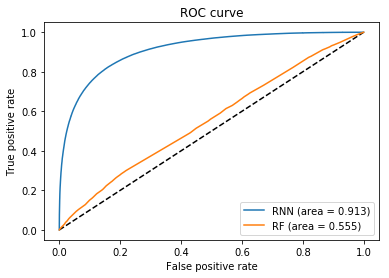

In [98]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='RNN (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("neg_exp_lstm2.png")
plt.show()


Predict tweets data

In [55]:
## open tweets data
tweets_filename = os.listdir("./tweets_data")[0]
tweets_path = os.path.join(".","tweets_data","movie_star_text.csv")
print("Open file:", tweets_path)
df_tweets = pd.read_csv(tweets_path, encoding =DATASET_ENCODING)
#df.iloc[0:5] = df.head(5)
print(df_tweets.head(5))


Open file: .\tweets_data\movie_star_text.csv
      user_id             status_id  \
0  x168508466  x1139246208608866305   
1  x168508466  x1139245583930204161   
2  x168508466  x1139244815022006277   
3  x168508466  x1139244768008032262   
4  x168508466  x1138400329802928128   

                                                text  
0  Real talk.. this woman is the ish<U+0001F525><...  
1  @bonang_m auditioning for Idols with with judg...  
2         @bonang_m Congrats Queen! Keep on Rising..  
3  @bonang_m You don't know how inspiring you Are...  
4  <U+0001F3C6> The #CarlingCup is back and the f...  


In [56]:
## remove https
df_tweets.text = df_tweets.text.apply(lambda x: preprocess(x))

In [57]:
print(df_tweets.head(5))
tweets_text = pad_sequences(tokenizer.texts_to_sequences(df_tweets.text), maxlen=SEQUENCE_LENGTH)

      user_id             status_id  \
0  x168508466  x1139246208608866305   
1  x168508466  x1139245583930204161   
2  x168508466  x1139244815022006277   
3  x168508466  x1139244768008032262   
4  x168508466  x1138400329802928128   

                                                text  
0  real talk.. this woman is the ish<u+0001f525><...  
1  @bonang_m auditioning for idols with with judg...  
2         @bonang_m congrats queen! keep on rising..  
3  @bonang_m you don't know how inspiring you are...  
4  <u+0001f3c6> the #carlingcup is back and the f...  


In [58]:
%%time
tweets_pred = model.predict(tweets_text)

Wall time: 48min 12s


In [59]:
print(tweets_pred[1:5])
df_tweets_pred = pd.DataFrame(data=tweets_pred)
df_tweets_pred.to_csv("./tweets_data/movie_star_pred.csv", index = False)

[[0.92295945]
 [0.99032235]
 [0.9461758 ]
 [0.85476667]]


In [214]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [215]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [216]:
print("I hate the rain: ", predict("I hate the rain"), end='\n')
print("I love the music: ", predict("I love the music"), end='\n')
print("i don't know what i'm doing: ", predict("i don't know what i'm doing"), end='\n')
print("I can't be any happier: ", predict("I can't be any happier"))
print("I am not unhappy: ", predict("I am not unhappy"))
print("I could be much happier: ", predict("I could be much happier"))
print("I can't sleep. That voice is repeating in my head: ", predict("I can't sleep. That voice is repeating in my head."))
print("I don't know where I'm going to in my life: ", predict("I don't know where I'm going to in my life"))
print("I don't know her: ", predict("I don't know her"))

I hate the rain:  {'label': 'NEGATIVE', 'score': 0.0048685078509151936, 'elapsed_time': 0.0}
I love the music:  {'label': 'POSITIVE', 'score': 0.9940224289894104, 'elapsed_time': 0.015594005584716797}
i don't know what i'm doing:  {'label': 'NEGATIVE', 'score': 0.04456508904695511, 'elapsed_time': 0.0}
I can't be any happier:  {'label': 'NEGATIVE', 'score': 0.08208955824375153, 'elapsed_time': 0.015620946884155273}
I am not unhappy:  {'label': 'NEGATIVE', 'score': 0.3581579923629761, 'elapsed_time': 0.0}
I could be much happier:  {'label': 'POSITIVE', 'score': 0.9099314212799072, 'elapsed_time': 0.0}
I can't sleep. That voice is repeating in my head:  {'label': 'NEGATIVE', 'score': 0.047460030764341354, 'elapsed_time': 0.015620946884155273}
I don't know where I'm going to in my life:  {'label': 'NEGATIVE', 'score': 0.04947482794523239, 'elapsed_time': 0.0}
I don't know her:  {'label': 'NEGATIVE', 'score': 0.12704114615917206, 'elapsed_time': 0.015621423721313477}


In [57]:
print(y_pred[0])

[9.208918e-06]


Confusion Matrix

In [30]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = y_pred
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

Wall time: 422 ms


In [31]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

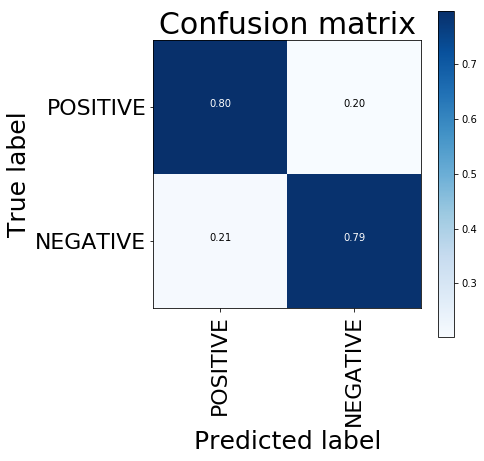

Wall time: 1.02 s


In [32]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

Classification Report

In [33]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.80      0.80    159494
    POSITIVE       0.80      0.79      0.80    160506

   micro avg       0.80      0.80      0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



Accuracy Score

In [34]:
accuracy_score(y_test_1d, y_pred_1d)

0.79530625

Save model

In [30]:
model.save("model_glove_lstm.h5")
#w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [8]:
#read splitted dataset
df_train = pd.read_csv("df_train.csv", encoding ="ISO-8859-1")
df_test = pd.read_csv("df_test.csv", encoding ="ISO-8859-1")
df_train['text'] = df_train['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

In [9]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())
y_test = y_test.reshape(-1,1)

In [11]:
print(y_test.shape)

(320000, 1)


In [5]:
from keras.models import load_model
model_lstm = load_model("model_LSTM.h5")

from sklearn.metrics import roc_curve
tokenizer = Tokenizer()
x_test_lstm = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)
y_pred_lstm = model_lstm.predict(x_test_lstm, verbose=1, batch_size=8000)
y_pred_keras_lstm = y_pred_lstm.ravel()
fpr_keras_lstm, tpr_keras_lstm, thresholds_keras_lstm = roc_curve(y_test, y_pred_keras_lstm)




320000/320000 [==============================] - 5755s 18ms/step


NameError: name 'roc_curve' is not defined

In [10]:
np.save("fpr_lstm.npy", fpr_keras_lstm)
np.save("tpr_lstm.npy", tpr_keras_lstm)

In [40]:
from keras.models import load_model
model_cnnrnn = load_model("model_cnn&rnn.h5")

from sklearn.metrics import roc_curve
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
x_test_cnnrnn = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=56)
y_pred_cnnrnn = model_cnnrnn.predict(x_test_cnnrnn, verbose=1, batch_size=8000)
y_pred_keras_cnnrnn = y_pred_cnnrnn.ravel()


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras_cnnrnn)

#np.save("fpr_sqcnn.npy", fpr_keras_sqcnn)
#np.save("tpr_sqcnn.npy", tpr_keras_sqcnn)

320000/320000 [==============================] - 237s 739us/step


In [22]:
y_pred_keras = y_pred_cnnrnn.ravel()

In [44]:
print(fpr_keras_sqcnn.shape)

(113124,)


In [43]:
from keras.models import load_model
model_sqcnn = load_model("model_sequentialCNN.h5")

from sklearn.metrics import roc_curve
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
x_test_sqcnn = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)
y_pred_sqcnn = model_sqcnn.predict(x_test_sqcnn, verbose=1, batch_size=8000)
y_pred_keras_sqcnn = y_pred_sqcnn.ravel()


fpr_keras_sqcnn, tpr_keras_sqcnn, thresholds_keras_sqcnn = roc_curve(y_test, y_pred_keras_sqcnn)

np.save("fpr_sqcnn.npy", fpr_keras_sqcnn)
np.save("tpr_sqcnn.npy", tpr_keras_sqcnn)

320000/320000 [==============================] - 237s 740us/step


In [ ]:
from keras.models import load_model
model_textcnn = load_model("model_textcnn2.h5")

from sklearn.metrics import roc_curve
tokenizer = Tokenizer()
x_test_textcnn = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)
y_pred_textcnn = model_textcnn.predict(x_test_textcnn, verbose=1, batch_size=8000)
y_pred_keras_textcnn = y_pred_textcnn.ravel()


fpr_keras_textcnn, tpr_keras_textcnn, thresholds_keras_textcnn = roc_curve(y_test, y_pred_keras_textcnn)

np.save("fpr_textcnn.npy", fpr_keras_textcnn)
np.save("tpr_textcnn.npy", tpr_keras_textcnn)

Instructions for updating:
Colocations handled automatically by placer.


2019-05-14 23:00:25,408 : WARNING : From C:\Users\lings\.conda\envs\sentiment\lib\site-packages\tensorflow\python\framework\op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-05-14 23:00:26,089 : WARNING : From C:\Users\lings\.conda\envs\sentiment\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


2019-05-14 23:00:27,527 : WARNING : From C:\Users\lings\.conda\envs\sentiment\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


In [49]:
fpr_keras_cnnrnn = np.load("./fprtpr/fpr_cnnrnn.npy")
tpr_keras_cnnrnn = np.load("./fprtpr/tpr_cnnrnn.npy")

fpr_keras_lstm = np.load("./fprtpr/fpr_lstm.npy")
tpr_keras_lstm = np.load("./fprtpr/tpr_lstm.npy")

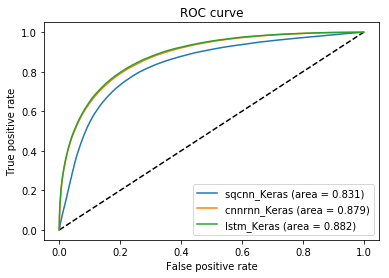

In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
auc_keras_sqcnn = auc(fpr_keras_sqcnn, tpr_keras_sqcnn)
auc_keras_cnnrnn = auc(fpr_keras_cnnrnn, tpr_keras_cnnrnn)
auc_keras_lstm = auc(fpr_keras_lstm, tpr_keras_lstm)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_sqcnn, tpr_keras_sqcnn, label='sqcnn_Keras (area = {:.3f})'.format(auc_keras_sqcnn))
plt.plot(fpr_keras_cnnrnn, tpr_keras_cnnrnn, label='cnnrnn_Keras (area = {:.3f})'.format(auc_keras_cnnrnn))
plt.plot(fpr_keras_lstm, tpr_keras_lstm, label='lstm_Keras (area = {:.3f})'.format(auc_keras_lstm))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()